# Recurrent Neural Network - LSTM -  BTC

### Importing Libraries

In [1]:
import _pickle as pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.style.use("ggplot")
from sklearn.preprocessing import StandardScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional

Using TensorFlow backend.


### Loading the Data

In [2]:
df = pd.read_csv("BTC-USD.csv")

## Preprocessing Data

In [9]:
# Setting the datetime index as the date, only selecting the 'Close' column, then only the last 1000 closing prices.
df = df.set_index("Date")[['Close']].tail(1000)

In [11]:
# Checking the newly formatted DataFrame
df.head()

,Close
Date,
2017-02-11,1004.450012
2017-02-12,999.181030
2017-02-13,990.642029
2017-02-14,1004.549988
2017-02-15,1007.479980


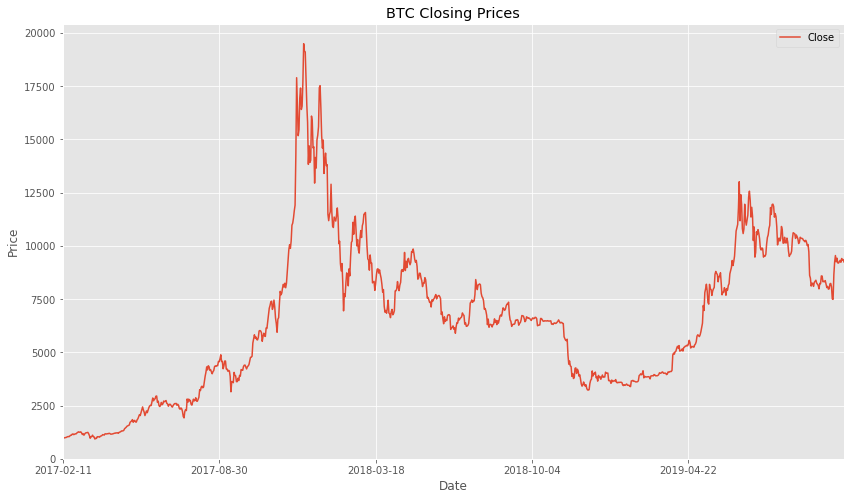

In [17]:
# Plotting the Closing Prices
df.plot(figsize=(14,8))
plt.title("BTC Closing Prices")
plt.ylabel("Price")
plt.show()

### Functions to prepare the data for LSTM

In [3]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """
    Splits the univariate time sequence
    """
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [4]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

### Splitting the Data

In [5]:
# How many periods looking back to predict
n_per_in  = 24

# How many periods to predict
n_per_out = 12

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))


## Modeling - LSTM (RNN)

### Creating the Neural Network

In [6]:
# Instatiating the model
model = Sequential()

# Activation
activ = "tanh"

# Input layer
model.add(LSTM(50, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
for _ in range(10):
    model.add(LSTM(50, activation=activ, return_sequences=True))
    
# Final Hidden Layer
model.add(LSTM(50, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 24, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
lstm_4 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 24, 50)            20200     
_________________________________________________________________
lstm_7 (LSTM)                (None, 24, 50)           

In [7]:
# Compiling the data with specifications
model.compile(optimizer='adamax', loss='mse', metrics=['accuracy'])

### Fitting and Training the RNN

In [9]:
res = model.fit(X, y, epochs=100, batch_size=4, validation_split=0.05)

Train on 916 samples, validate on 49 samples
Epoch 1/100
916/916 [==============================] - 24s 27ms/step - loss: 7.0771 - accuracy: 0.1354 - val_loss: 43.1285 - val_accuracy: 0.1224
Epoch 2/100
916/916 [==============================] - 25s 27ms/step - loss: 6.8981 - accuracy: 0.1485 - val_loss: 35.9768 - val_accuracy: 0.1224
Epoch 3/100
916/916 [==============================] - 25s 28ms/step - loss: 6.5632 - accuracy: 0.1419 - val_loss: 29.6989 - val_accuracy: 0.1429
Epoch 4/100
916/916 [==============================] - 26s 28ms/step - loss: 6.2037 - accuracy: 0.1550 - val_loss: 43.0567 - val_accuracy: 0.1224
Epoch 5/100
916/916 [==============================] - 24s 27ms/step - loss: 6.4312 - accuracy: 0.1441 - val_loss: 37.2274 - val_accuracy: 0.1224
Epoch 6/100
916/916 [==============================] - 24s 26ms/step - loss: 5.7781 - accuracy: 0.1255 - val_loss: 37.6876 - val_accuracy: 0.1020
Epoch 7/100
916/916 [==============================] - 24s 26ms/step - loss: 5.

### Plotting the Accuracy and Loss

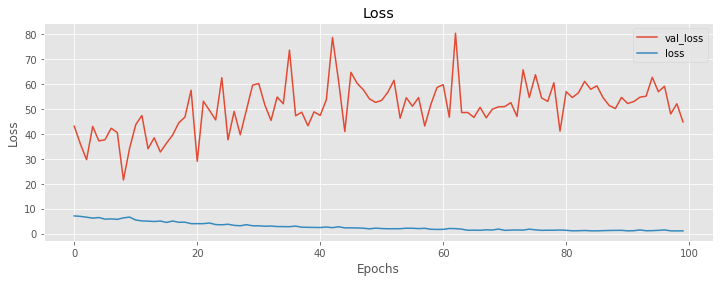

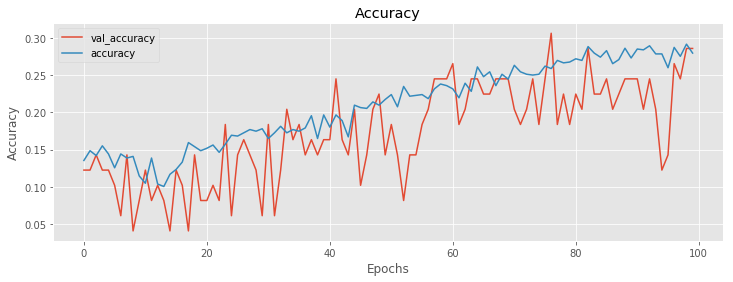

In [10]:
visualize_training_results(res)

### Visualizing the Predictions

#### Plotting the difference between the Actual closing prices and the Predicted prices

Predicted:
 [28.350072860717773, 29.41823387145996, 30.581125259399414, 31.817899703979492, 32.82400894165039, 34.53569412231445, 36.10035705566406, 37.56895065307617, 38.63870620727539, 39.86128234863281, 40.17037582397461, 39.889339447021484]

Actual:
 [28.219998999999998, 27.959999, 27.5, 26.440001000000002, 27.41, 32.41, 30.360001, 29.1, 30.370001000000002, 31.5, 33.209998999999996, 32.509997999999996]


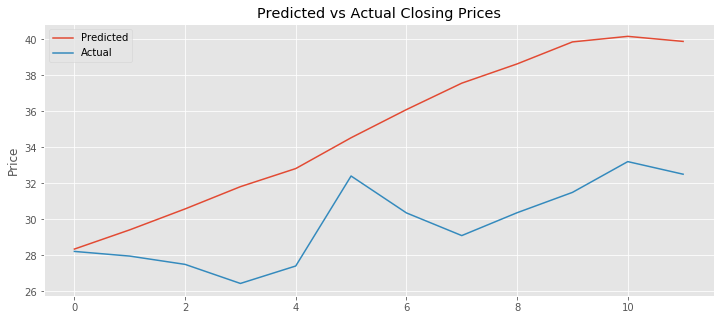

In [11]:
plt.figure(figsize=(12,5))
# Getting predictions
yhat = model.predict(X[-n_per_out].reshape(1, n_per_in, n_features)).tolist()[0]

# Printing and plotting those predictions
print("Predicted:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual:\n", y[-n_per_out].tolist())
plt.plot(y[-n_per_out].tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.show()

#### Predicting/Forecasting the future prices

Predicted Prices:
 [30.8502197265625, 30.1529541015625, 29.345603942871094, 28.16377830505371, 26.709259033203125, 25.4305477142334, 24.192201614379883, 22.74541473388672, 21.59356689453125, 20.773649215698242, 20.129192352294922, 19.315649032592773]


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


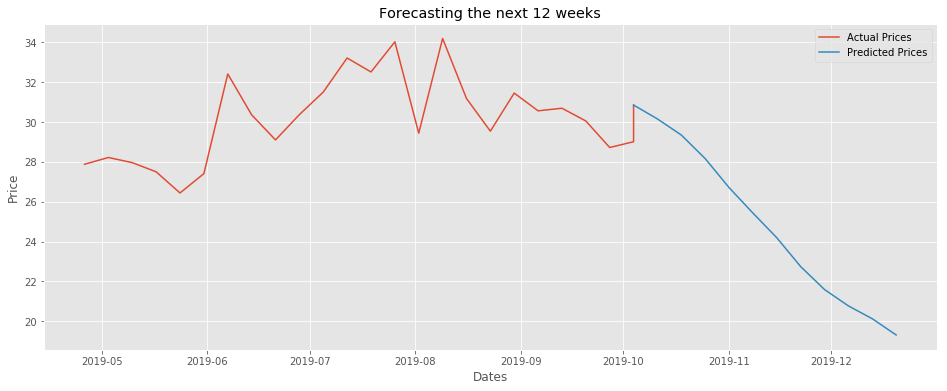

In [12]:
# Predicting off of y because it contains the most recent dates
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]
print("Predicted Prices:\n",yhat)

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="1W-FRI"))

# Number of periods back to visualize the actual values
pers = 24

# Plotting
plt.figure(figsize=(16,6))
plt.plot(df.Close.tail(pers).append(preds.head(1)), label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} weeks")
plt.legend()
plt.show()